In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from Bio import Phylo
from scipy.optimize import curve_fit

sns.set_style('white')

### Download all data

- [x] `parsnp.nwk` for **Accessory Binary Genes (Newick)**  
- [x] `Gene Presence Absence.txt` for **Gene Presence Absence (Rtab)**  
- [x] `Number of Conserved Genes.txt` for **Number of Conserved Genes (Rtab)**  
- [x] `Number of Genes in Pan Geneome.txt` for **Number of Genes in Pan Geneome (Rtab)**

In [2]:
t = Phylo.read('parsnp.nwk', 'newick')
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

roary = pd.read_table('Gene Presence Absence.txt', index_col=0)
idx = roary.sum(axis=1).sort_values(ascending=False).index
roary_sorted = roary.loc[idx]
roary_sorted = roary_sorted[[x.name for x in t.get_terminals()]]

pan_df = pd.read_table('Number of Genes in Pan Geneome.txt', header=None)
pan_df = pan_df.melt().rename(columns={'value':'pan'})

core_df = pd.read_table('Number of Conserved Genes.txt', header=None)
core_df = core_df.melt().rename(columns={'value':'core'})

df = pan_df.merge(core_df, left_index=True, right_index=True)
df = df[['variable_x','pan','core']].rename(columns={'variable_x':'N_of_genomes'})
df['N_of_genomes'] = df['N_of_genomes']+1

### Pan-genome structure

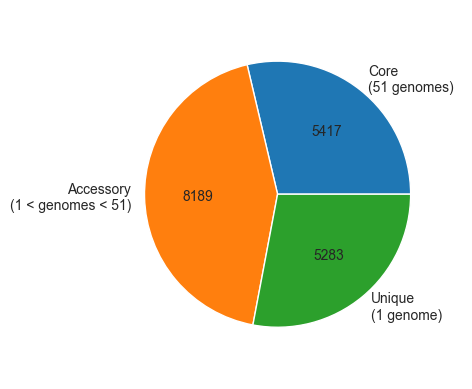

In [3]:
core = roary[roary.sum(axis=1) == roary.shape[1]].shape[0]
accessory = roary[(roary.sum(axis=1) < roary.shape[1]) & (roary.sum(axis=1) > 1)].shape[0]
unique = roary[roary.sum(axis=1) == 1].shape[0]
total = roary.shape[0]

def my_autopct(pct):
    val=int((pct*total/100.0)+0.5)
    return '{v:d}'.format(v=val)

a=plt.pie([core, accessory, unique],
      labels=['Core\n(%d genomes)'%roary.shape[1],
              'Accessory\n(1 < genomes < %d)'%(roary.shape[1]),
              'Unique\n(1 genome)'
             ],
      radius=0.9,
      autopct=my_autopct)
plt.show();
#fig.savefig('pan_structure.png')

### Presence-absence matrix against the tree

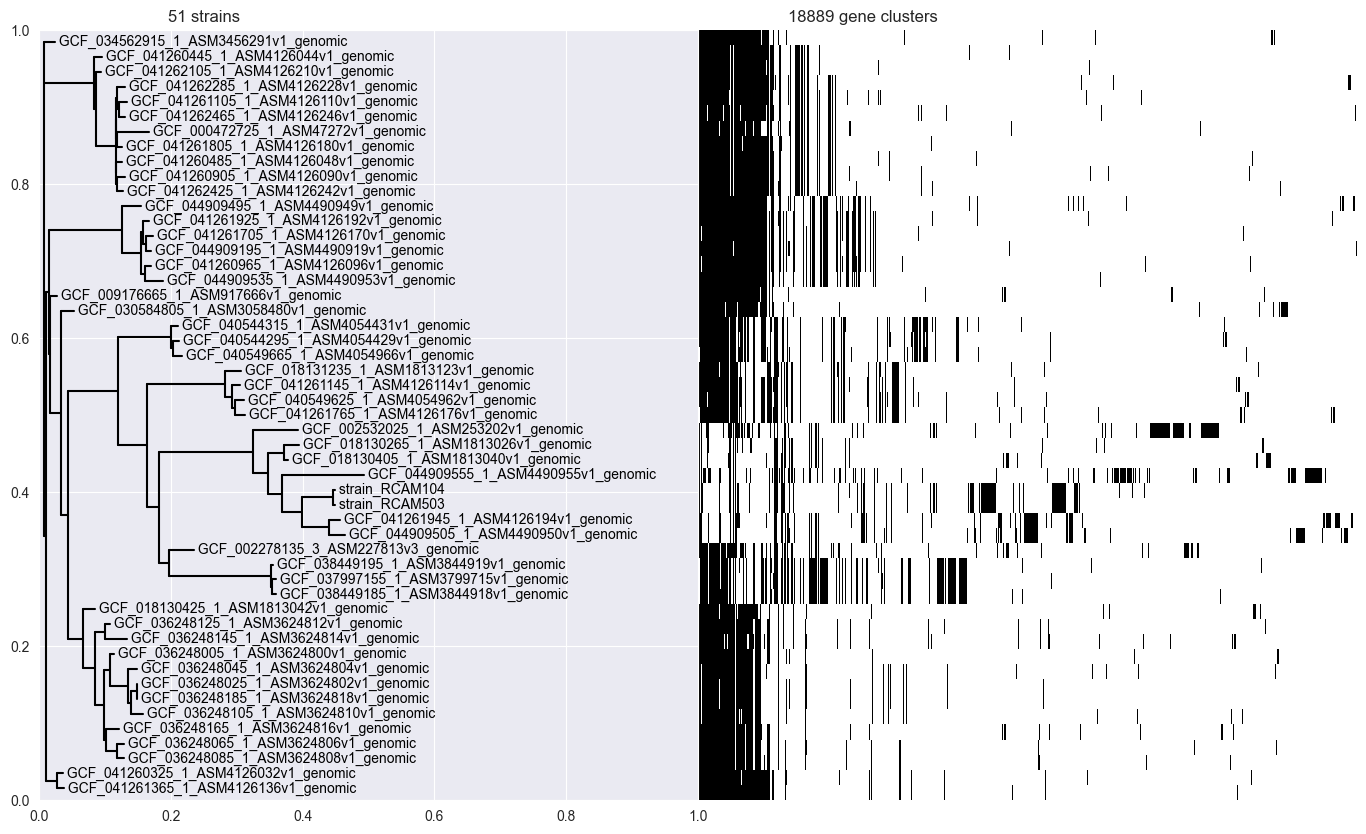

In [4]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(17, 10))
    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(roary_sorted.T, cmap=plt.cm.binary,
                   vmin=0, vmax=1,
                   aspect='auto',
                   interpolation='none')
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')
    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, facecolor='black')
    fig.subplots_adjust(wspace=0, hspace=0)
    ax1.set_title('%d gene clusters'%roary.shape[0])
    
    Phylo.draw(t, axes=ax, 
                   show_confidence=False,
                   #xticks=([],), yticks=([],),
                   ylabel=('',), xlabel=('',),
                   xlim=(-0.01,mdist+0.01),
                   axis=('off',),
                   title=('%d strains'%roary.shape[1],))
    plt.show();
    #fig.savefig('pan_matrix.png')

### Pan-genome model prediction

In [5]:
core_array = []
for i in df.N_of_genomes.unique().tolist():
    value = df[df.N_of_genomes == i].core.mean()
    core_array.append(value)
    
pan_array = []
for i in df.N_of_genomes.unique().tolist():
   value = df[df.N_of_genomes == i].pan.mean()
   pan_array.append(value)
    
core = pd.DataFrame(core_array,columns=['mean'])
core['N_of_genomes'] = df.N_of_genomes.unique().tolist()
pan = pd.DataFrame(pan_array,columns=['mean'])
pan['N_of_genomes'] = df.N_of_genomes.unique().tolist()

Ω = 5583


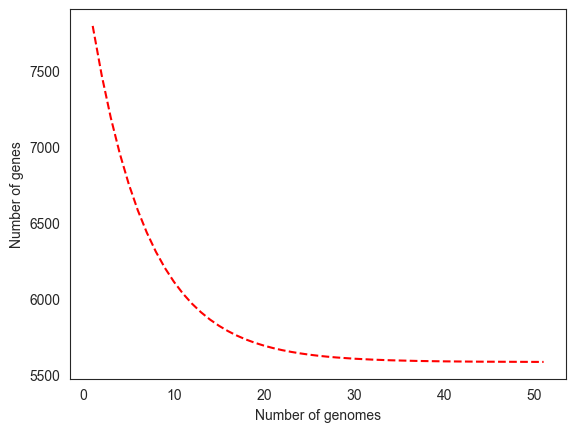

In [7]:
def exp_func(x, K, t, omega):
    return K * np.exp(-x / t) + omega

popt_core, pcov_core = curve_fit(exp_func, df['N_of_genomes'], df['core'], p0=[df.core.max(), 0.1, 0])
print("Ω =", round(popt_core[2]))

fig = plt.plot(df['N_of_genomes'], exp_func(df['N_of_genomes'], *popt_core), 'r--')
plt.xlabel('Number of genomes')
plt.ylabel('Number of genes')
plt.show();
#fig.savefig('pan_core.png')

The evaluated **core genome size** is `Ω`.

γ = 0.2581268132648777


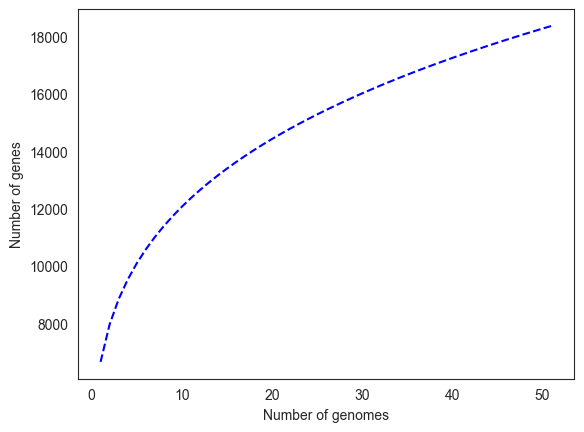

In [8]:
def heaps_law(x, K, gamma):
    return K * x**(gamma)

popt_pan, cov_pan = curve_fit(heaps_law, df['N_of_genomes'], df['pan'])
print("γ =", popt_pan[1])

fig = plt.plot(df['N_of_genomes'], heaps_law(df['N_of_genomes'], *popt_pan), 'b--')
plt.xlabel('Number of genomes')
plt.ylabel('Number of genes')
plt.show();
#fig.savefig('pan_pan.png')

If `γ < 0`, the pan-genome is **closed**; else if `γ > 0`, the pangenome is **open**.

### Models QC by coefficient of determination (R-square)

In [9]:
from sklearn.metrics import r2_score

y_pred_core = exp_func(df['N_of_genomes'], *popt_core)
print('Core genome fit R-square:', r2_score(df['core'], y_pred_core))
y_pred_pan = heaps_law(df['N_of_genomes'], *popt_pan)
print('Pan-genome fit R-square:', r2_score(df['pan'], y_pred_pan))

Core genome fit R-square: 0.9068197206384612
Pan-genome fit R-square: 0.9185206764002801
